In [ ]:
#Import neccessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from google.colab import files
import zipfile
from google.colab import files
import os

In [ ]:
# Install the Kaggle API library and its dependencies.
!pip install kaggle --upgrade --quiet

In [ ]:
# Upload your kaggle.json file
print("Please upload your kaggle.json API file.")
files.upload()

In [ ]:
# Set up the Kaggle API client
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
DATASET_API_COMMAND = "kaggle datasets download samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc"
# The name of the zip file to expect.
ZIP_FILE_NAME = "genomics-of-drug-sensitivity-in-cancer-gdsc.zip"
# The directory to extract the files into.
EXTRACTION_DIR = "./gdsc-dataset"

In [ ]:
print("\nDownloading dataset...")
!$DATASET_API_COMMAND


Dataset URL: https://www.kaggle.com/datasets/samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc
License(s): GPL-3.0
  0% 0.00/14.4M [00:00<?, ?B/s]
100% 14.4M/14.4M [00:00<00:00, 1.29GB/s]


In [ ]:
#Unzip the dataset into the specified directory
if os.path.exists(ZIP_FILE_NAME):
    os.makedirs(EXTRACTION_DIR, exist_ok=True)
    with zipfile.ZipFile(ZIP_FILE_NAME, 'r') as zip_ref:
        zip_ref.extractall(EXTRACTION_DIR)
    print(f"Extraction of {ZIP_FILE_NAME} completed to {EXTRACTION_DIR}/")
    os.remove(ZIP_FILE_NAME)
else:
    print(f"Error: {ZIP_FILE_NAME} not found. Please check the dataset API command.")

Extraction of genomics-of-drug-sensitivity-in-cancer-gdsc.zip completed to ./gdsc-dataset/


In [ ]:
#Verify the files are extracted
print("\nExtracted files are available at:", EXTRACTION_DIR)
print("Listing contents of the extraction directory:")
!ls -F {EXTRACTION_DIR}


Extracted files are available at: ./gdsc-dataset
Listing contents of the extraction directory:
Cell_Lines_Details.xlsx   GDSC2-dataset.csv
Compounds-annotation.csv  GDSC_DATASET.csv


In [ ]:
# The EXTRACTION_DIR is already defined and populated by the first cell.
# Define the file paths for each CSV file.
gdsc_dataset_file_path = os.path.join(EXTRACTION_DIR, 'GDSC_DATASET.csv')
gdsc_dataset2_file_path = os.path.join(EXTRACTION_DIR, 'GDSC2-dataset.csv')

In [ ]:
# Load the datasets into pandas DataFrames.
gdsc_df = pd.read_csv(gdsc_dataset_file_path)
drug_conc_df = pd.read_csv(gdsc_dataset2_file_path)

In [ ]:
#Viewing initial content of the dataset.
print(gdsc_df.head())

   COSMIC_ID CELL_LINE_NAME     TCGA_DESC  DRUG_ID     DRUG_NAME   LN_IC50  \
0     683667         PFSK-1            MB     1003  Camptothecin -1.463887   
1     684057            ES5  UNCLASSIFIED     1003  Camptothecin -3.360586   
2     684059            ES7  UNCLASSIFIED     1003  Camptothecin -5.044940   
3     684062          EW-11  UNCLASSIFIED     1003  Camptothecin -3.741991   
4     684072        SK-ES-1  UNCLASSIFIED     1003  Camptothecin -5.142961   

        AUC   Z_SCORE GDSC Tissue descriptor 1 GDSC Tissue descriptor 2  \
0  0.930220  0.433123           nervous_system          medulloblastoma   
1  0.791072 -0.599569                     bone           ewings_sarcoma   
2  0.592660 -1.516647                     bone           ewings_sarcoma   
3  0.734047 -0.807232                     bone           ewings_sarcoma   
4  0.582439 -1.570016                     bone           ewings_sarcoma   

  Cancer Type (matching TCGA label) Microsatellite instability Status (MSI)  \
0

In [ ]:
#Viewing statistical information of the dataset.
print(gdsc_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242035 entries, 0 to 242034
Data columns (total 19 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   COSMIC_ID                                242035 non-null  int64  
 1   CELL_LINE_NAME                           242035 non-null  object 
 2   TCGA_DESC                                240968 non-null  object 
 3   DRUG_ID                                  242035 non-null  int64  
 4   DRUG_NAME                                242035 non-null  object 
 5   LN_IC50                                  242035 non-null  float64
 6   AUC                                      242035 non-null  float64
 7   Z_SCORE                                  242035 non-null  float64
 8   GDSC Tissue descriptor 1                 232669 non-null  object 
 9   GDSC Tissue descriptor 2                 232669 non-null  object 
 10  Cancer Type (matching TCGA label

In [ ]:
#Finding different cancer types in GDSC dataset
print("Unique cancer types in dataset:", gdsc_df['TCGA_DESC'].unique())

Unique cancer types in dataset: ['MB' 'UNCLASSIFIED' 'SKCM' 'BLCA' 'CESC' 'GBM' 'LUAD' 'LUSC' 'SCLC'
 'MESO' 'NB' 'MM' 'PAAD' 'ESCA' 'BRCA' 'HNSC' 'KIRC' 'LAML' 'OV' 'PRAD'
 'COREAD' 'LCML' 'ALL' 'LGG' nan 'THCA' 'STAD' 'DLBC' 'UCEC' 'LIHC' 'CLL'
 'ACC' 'OTHER']


In [ ]:
# Filter the main GDSC dataset to include only breast cancer cell lines.
# The `.copy()` method is used to ensure we are working on a new, independent DataFrame
breast_cancer_df = gdsc_df[gdsc_df['TCGA_DESC'] == 'BRCA'].copy()
# Merge the breast cancer data with drug concentration details.
# The merge is performed on 'DRUG_ID', with a 'left' join to ensure all breast cancer
# rows are kept, and concentration data is added only for matching Drug IDs.
merged_df = pd.merge(breast_cancer_df, drug_conc_df[['DRUG_ID', 'MAX_CONC', 'MIN_CONC']], on='DRUG_ID', how='left')
# The `dropna` function is used here to remove any rows where there was no matching
merged_df.dropna(subset=['MAX_CONC', 'MIN_CONC'], inplace=True)

In [ ]:
#Compare the size of origional dataset with the filtered dataset.
print(f"Original dataset size: {gdsc_df.shape[0]} rows")
print(f"Filtered breast cancer dataset size: {breast_cancer_df.shape[0]} rows")

Original dataset size: 242035 rows
Filtered breast cancer dataset size: 13106 rows


In [ ]:
#Inspecct merged dataset.
print(f"\nMerged dataset size: {merged_df.shape} rows")
print("\nMerged DataFrame head:")
print(merged_df.head())


Merged dataset size: (11121246, 21) rows

Merged DataFrame head:
   COSMIC_ID CELL_LINE_NAME TCGA_DESC  DRUG_ID     DRUG_NAME   LN_IC50  \
0     749709        HCC1954      BRCA     1003  Camptothecin  0.317741   
1     749709        HCC1954      BRCA     1003  Camptothecin  0.317741   
2     749709        HCC1954      BRCA     1003  Camptothecin  0.317741   
3     749709        HCC1954      BRCA     1003  Camptothecin  0.317741   
4     749709        HCC1954      BRCA     1003  Camptothecin  0.317741   

        AUC   Z_SCORE GDSC Tissue descriptor 1 GDSC Tissue descriptor 2  ...  \
0  0.983262  1.403164                   breast                   breast  ...   
1  0.983262  1.403164                   breast                   breast  ...   
2  0.983262  1.403164                   breast                   breast  ...   
3  0.983262  1.403164                   breast                   breast  ...   
4  0.983262  1.403164                   breast                   breast  ...   

  Micros

In [ ]:
# Define the target variable.
target = 'LN_IC50'

In [ ]:
#Feature selection.
features = ['DRUG_NAME', 'TARGET_PATHWAY', 'TARGET', 'MAX_CONC', 'MIN_CONC']

In [ ]:
#Features on x and Target on y axis.
X = merged_df[features]
y = merged_df[target]

In [ ]:
# Define numerical and categorical features for preprocessing.
categorical_features = ['DRUG_NAME', 'TARGET_PATHWAY', 'TARGET']
numerical_features = ['MAX_CONC', 'MIN_CONC']

In [ ]:
#Standardisation for numerical features and one hot encoding for categorical features.
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [ ]:
# Create preprocessing pipelines for numerical (StandardScaler) and categorical (OneHotEncoder) data.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

In [ ]:
# Split the data into training and testing sets. `random_state=42` ensures the split is reproducible.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [ ]:
# Create the final model pipeline that preprocesses and then trains the regressor.
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [ ]:
# Train the model pipeline on the training data.
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['MAX_CONC', 'MIN_CONC']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DRUG_NAME',
                                                   'TARGET_PATHWAY',
                                                   'TARGET'])])),
                ('regressor', LinearRegression())])

In [ ]:
# Make predictions on the held-out test data.
y_pred = model.predict(X_test)

In [ ]:
# Evaluate the model's performance using standard regression metrics.
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [ ]:
print(f"\nMean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")


Mean Squared Error (MSE): 1.9527
Root Mean Squared Error (RMSE): 1.3974
R-squared (R2): 0.7231


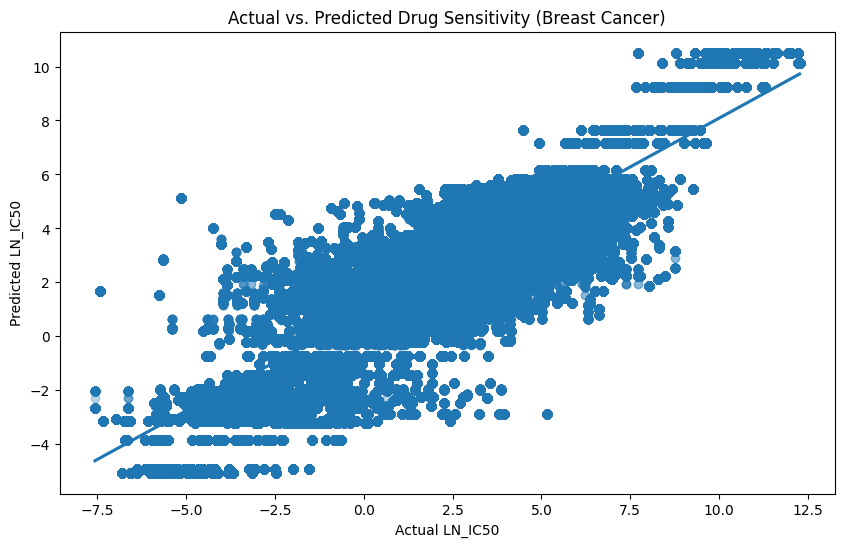

In [ ]:
# Create the plot to visualize predicted vs. actual values.
plt.figure(figsize=(10, 6))
# sns.regplot plots the scatter points and a regression line to show the trend.
# `scatter_kws={'alpha': 0.3}` makes the points semi-transparent to better visualize density.
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.3})
plt.xlabel("Actual LN_IC50")
plt.ylabel("Predicted LN_IC50")
plt.title("Actual vs. Predicted Drug Sensitivity (Breast Cancer)")
plt.show()